# Playground-series-s3e26

Kyle Lacson 


## I. Libraries and Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os 
import warnings
warnings.filterwarnings('ignore')

### I.ii Import dataset

In [2]:
# --- Setting up the directory based on local repository or kaggle
if 'kylelacson' in os.getcwd():
    base_dir = os.getcwd()
else:
    base_dir = r'/kaggle/input/playground-series-s3e26' 
    
for i in os.listdir(base_dir):
    if 'playground-series-s3e26' in i:
        base_dir = os.path.join(base_dir,i)   
    
# --- Importing csv files from directory
for i in os.listdir(base_dir):
    if 'sample' in i:
        sample = pd.read_csv(os.path.join(base_dir,i))
    elif 'train' in i:
        train = pd.read_csv(os.path.join(base_dir,i))
    elif 'test' in i:
        test = pd.read_csv(os.path.join(base_dir,i))
    else:
        continue

In [3]:
train.nunique().sort_values()[:10]

Drug              2
Sex               2
Ascites           2
Hepatomegaly      2
Spiders           2
Status            3
Edema             3
Stage             4
Prothrombin      49
Bilirubin       111
dtype: int64

### I.iii Transfrom dataset

In [4]:
# --- Setting aside category/object columns to transform
category = train.select_dtypes(include = object)
number = train.select_dtypes(include = np.number)

In [5]:
from sklearn.preprocessing import LabelEncoder
'''
Function: Label encode categorical columns.
'''
def label_encoder(df: pd.DataFrame):
    for i in df.columns:
        le = LabelEncoder()
        le.fit(df[i])
        df[i] = le.transform(df[i])
    return df

In [6]:
# --- Initializing label_encoder function
category = label_encoder(category)

In [7]:
# --- Merging the new initialized dataset
data = pd.concat([number,category],axis = 1).drop(columns = 'id')

In [8]:
data.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
0,999,21532,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,0,1,0,0,0,0,2
1,2574,19237,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,1,0,0,0,0,0,0
2,3428,13727,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,1,0,0,1,1,2,2
3,2576,18460,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,1,0,0,0,0,0,0
4,788,16658,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,1,0,0,1,0,0,0


## II. Explore data 

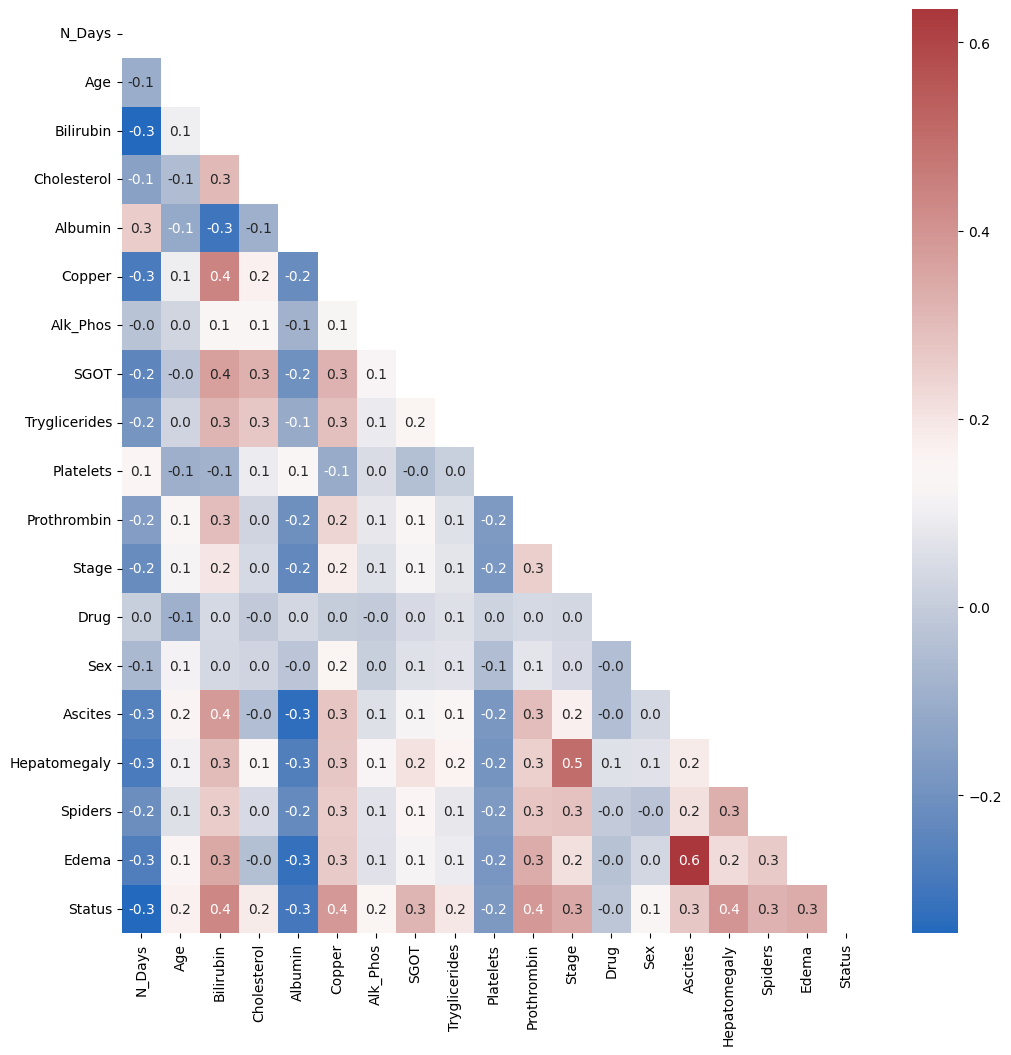

In [9]:
# --- Heatmap
plt.figure(figsize = (12,12))
mask = np.triu(np.ones_like(data.corr()))
sns.heatmap(data = data.corr(), annot = True, fmt = '.1f', cmap = 'vlag', mask = mask);

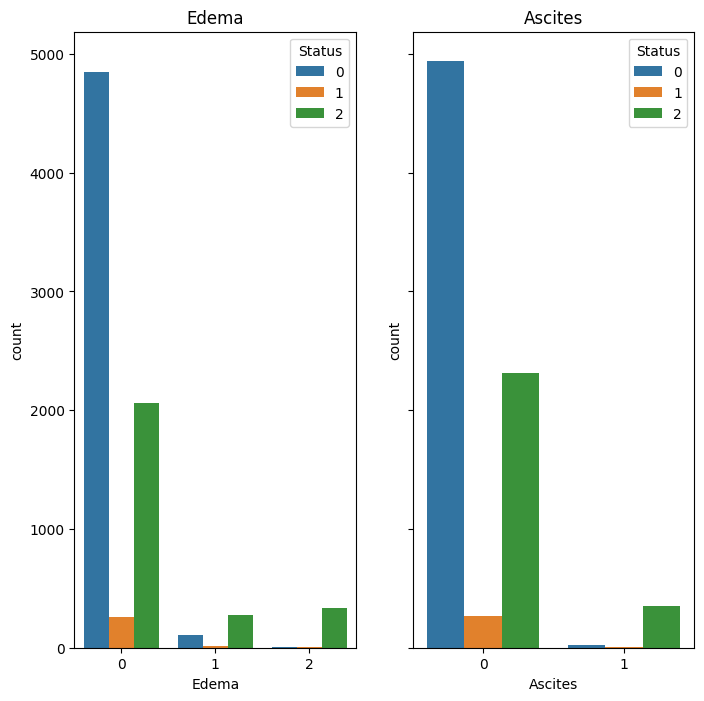

In [10]:
#  Ascites & Edema
fig, ax = plt.subplots(1,2,figsize = (8,8), sharey = True)
sns.countplot(data = data, x = 'Edema', hue = 'Status', ax = ax[0])
sns.countplot(data = data, x = 'Ascites', hue = 'Status', ax = ax[1])
ax[0].set_title('Edema')
ax[1].set_title('Ascites');


### II.ii  Prepare dataset

In [11]:
# --- Split dataset
from sklearn.model_selection import train_test_split
X = data.drop(columns = 'Status')
y = data.Status

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, shuffle = True)

# --- Creating a valdiation set 
train_split = int(len(X_train) * 0.10) # 10 percent of the split training set will be used for the evalution set 
X_val, y_val = X_train[(len(X_train) - train_split):], y_train[(len(y_train) - train_split):]
X_train, y_train = X_train[:(len(X_train) - train_split)], y_train[:(len(y_train) - train_split)]

In [12]:
# --- Scaling dataset (not truly needed for tree based classifiers)
from sklearn.preprocessing import StandardScaler

def scale_dataframes(dataframe: pd.DataFrame):
    scaler = StandardScaler()
    df = pd.DataFrame(data = scaler.fit_transform(dataframe), columns = dataframe.columns)
    return df

In [13]:
X_train_sc = scale_dataframes(X_train)
X_val_sc = scale_dataframes(X_val)
X_test_sc =  scale_dataframes(X_test)

## III. Classification Modeling

### III.ii Decision Tree Classifier (SKLEARN)

In [14]:
# --- Sklearn Decision Tree Classifier 
from sklearn.tree import DecisionTreeClassifier

dt_sk = DecisionTreeClassifier(random_state = 42)
dt_sk.fit(X_train_sc, y_train)
y_dt_pred = dt_sk.predict(X_test_sc)
y_dt_prob_pred = dt_sk.predict_proba(X_test_sc)

### III.iii Random Forest Classifier (SKLEARN)

In [15]:
# --- Sklearn Random Forest Tree Classifier
from sklearn.ensemble import RandomForestClassifier

rf_sk = RandomForestClassifier(random_state = 42)
rf_sk.fit(X_train_sc, y_train)
y_rf_pred = rf_sk.predict(X_test_sc)
y_rf_prob_pred = rf_sk.predict_proba(X_test_sc)

### III.iv Random Forest XGBoost Classifier (Gradient Boosting) 

In [16]:
# --- Check if a GPU is available and set device to built in GPU support (MPS)
import torch
device = torch.device('mps') if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [17]:
# --- XGBoost Classifier and Random Forest Classifier
from xgboost import XGBClassifier, XGBRFClassifier

# Gradient Boosting
params = {
    'random_state': 42,
    'n_jobs': 4,
    'verbosity': 1,
    'device': device,
    'early_stopping_rounds': 10
    # eval_metric: # change log loss to multiclass entropy loss
}

params2 = {
    'random_state': 42,
    'n_jobs': 4,
    'verbosity': 1,
    'device': device
    # eval_metric: # change log loss to multiclass entropy loss
}

xgb_clf = XGBClassifier(**params)
xgb_clf.fit(X_train_sc, y_train, eval_set = [(X_train_sc, y_train),(X_val_sc, y_val)])
y_xgbclf_pred = xgb_clf.predict(X_test_sc)
y_xgbclf_prob_pred = xgb_clf.predict_proba(X_test_sc)

# Random Forest
xgbrf_clf = XGBRFClassifier(**params2)
xgbrf_clf.fit(X_train_sc, y_train, eval_set = [(X_train_sc, y_train), (X_val_sc, y_val)])
y_xgbrf_pred = xgbrf_clf.predict(X_test_sc)
y_xgbrf_prob_pred = xgbrf_clf.predict(X_test_sc)

[0]	validation_0-mlogloss:0.85280	validation_1-mlogloss:0.87376
[1]	validation_0-mlogloss:0.70571	validation_1-mlogloss:0.74553
[2]	validation_0-mlogloss:0.60600	validation_1-mlogloss:0.66873
[3]	validation_0-mlogloss:0.53803	validation_1-mlogloss:0.62012
[4]	validation_0-mlogloss:0.48873	validation_1-mlogloss:0.59128
[5]	validation_0-mlogloss:0.44947	validation_1-mlogloss:0.57328
[6]	validation_0-mlogloss:0.41816	validation_1-mlogloss:0.56225
[7]	validation_0-mlogloss:0.39274	validation_1-mlogloss:0.55517
[8]	validation_0-mlogloss:0.37198	validation_1-mlogloss:0.54854
[9]	validation_0-mlogloss:0.35552	validation_1-mlogloss:0.54849
[10]	validation_0-mlogloss:0.34121	validation_1-mlogloss:0.54520
[11]	validation_0-mlogloss:0.32750	validation_1-mlogloss:0.54133
[12]	validation_0-mlogloss:0.31640	validation_1-mlogloss:0.54093
[13]	validation_0-mlogloss:0.30681	validation_1-mlogloss:0.53866
[14]	validation_0-mlogloss:0.29745	validation_1-mlogloss:0.53546
[15]	validation_0-mlogloss:0.28928	

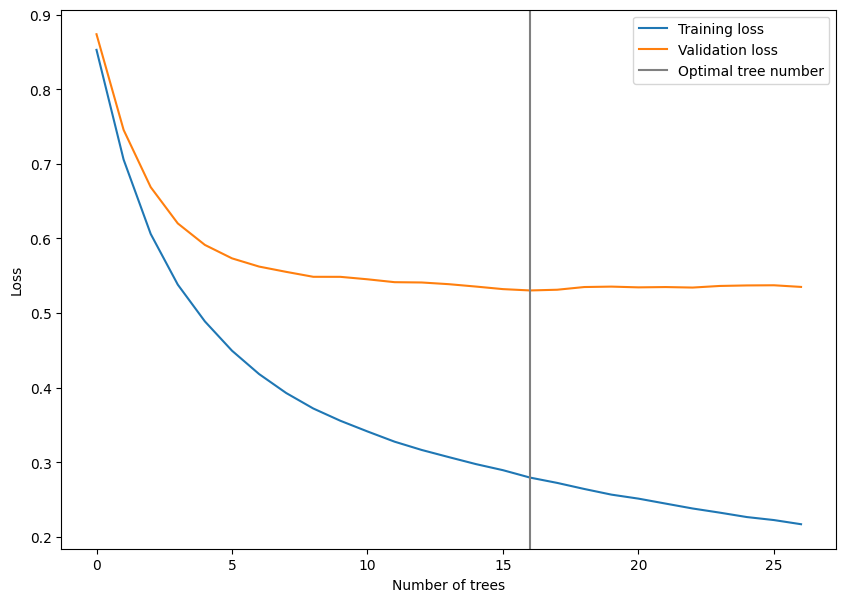

In [18]:
# --- xgbclassifier evaluation metrics
xgb_results = xgb_clf.evals_result_

plt.figure(figsize=(10,7))
plt.plot(xgb_results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(xgb_results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(xgb_clf.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

### III.v. Classifier Catboost

In [19]:
# --- Catboost Classifier
from catboost import CatBoostClassifier
import ipywidgets # required for plotting with catboosts

params = {
    'random_seed': 42, 
    'verbose': True,
    'thread_count': 4,
    'devices': 'CPU',
    'early_stopping_rounds': 25
}

cb_clf = CatBoostClassifier(**params)
cb_clf.fit(X_train_sc,y_train, verbose = True, early_stopping_rounds = 25, plot = True, eval_set = (X_val_sc, y_val))
y_cb_pred = cb_clf.predict(X_test_sc, thread_count = 4)
y_cb_prob_pred = cb_clf.predict_proba(X_test_sc, thread_count = 4)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.111798
0:	learn: 0.9892895	test: 0.9919968	best: 0.9919968 (0)	total: 62.3ms	remaining: 1m 2s
1:	learn: 0.9045884	test: 0.9078327	best: 0.9078327 (1)	total: 68.8ms	remaining: 34.3s
2:	learn: 0.8381543	test: 0.8439784	best: 0.8439784 (2)	total: 74.7ms	remaining: 24.8s
3:	learn: 0.7839609	test: 0.7903252	best: 0.7903252 (3)	total: 80.5ms	remaining: 20.1s
4:	learn: 0.7396798	test: 0.7471730	best: 0.7471730 (4)	total: 86ms	remaining: 17.1s
5:	learn: 0.7037519	test: 0.7126255	best: 0.7126255 (5)	total: 91.8ms	remaining: 15.2s
6:	learn: 0.6733087	test: 0.6825363	best: 0.6825363 (6)	total: 98.1ms	remaining: 13.9s
7:	learn: 0.6459126	test: 0.6564680	best: 0.6564680 (7)	total: 104ms	remaining: 12.9s
8:	learn: 0.6230300	test: 0.6341680	best: 0.6341680 (8)	total: 110ms	remaining: 12.1s
9:	learn: 0.6042912	test: 0.6169028	best: 0.6169028 (9)	total: 116ms	remaining: 11.5s
10:	learn: 0.5877277	test: 0.6007941	best: 0.6007941 (10)	total: 122ms	remaining: 11s
11:	learn: 0.572350

## IV. Metrics

In [20]:
# --- Creating a class to complete metrics 
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
class Metric:
    
    name_list = []
    classifier_list = []
    accuracy_list = []
    roc_list = []
    
    def __init__(self, name_of_classifier, classifier, y_pred, y_pred_prob):
        self.name = name_of_classifier
        self.y_pred = y_pred
        self.classifier = classifier
        self.y_pred_prob = y_pred_prob
        self.acc = accuracy_score(y_test, self.y_pred)
        try:
            self.roc = roc_auc_score(y_test,self.y_pred_prob, multi_class = 'ovr') # chose to use one vs rest
        except:
            self.roc = None
            print(f'ROC AUC is not available for this classifier: {self.name}.')
            
    '''
    Function: Provide metrics for a given classifier.
    '''
    def metrics_func(self):
        self.bal_acc = balanced_accuracy_score(y_test, self.y_pred)
        
        # --- Confusion Matrix
        cm = confusion_matrix(y_test, self.y_pred, labels = self.classifier.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = self.classifier.classes_)
        
        print('-'*75,'\n',self.name)
        disp.plot()
        plt.show()
        print(classification_report(y_test,self.y_pred))
        print('*'*75,'\n')
        print(f'Accuracy: {self.acc}\nBalanced Accuracy: {self.bal_acc}')
        
#     def append_metrics(self):
#         self.name_list.append(self.name)
#         self.classifier_list.append(self.classifier)
#         self.accuracy_list.append(self.acc)
#         self.roc_list.append(self.roc)
    '''
    Function: Appends to the Metric class variables.
    '''
    def append_metrics(self):
        Metric.name_list.append(self.name)
        Metric.classifier_list.append(self.classifier)
        Metric.accuracy_list.append(self.acc)
        Metric.roc_list.append(self.roc)
    '''
    Function: Clears the Metric class variables.
    '''   
    def clear_metrics():
        Metric.name_list.clear()
        Metric.classifier_list.clear()
        Metric.accuracy_list.clear()
        Metric.roc_list.clear()
        
    def create_dataframe():
        df_dict = {'Name_of_classifier': Metric.name_list,
                  'Classifier': Metric.classifier_list,
                  'Accuracy': Metric.accuracy_list,
                  'ROC': Metric.roc_list}
        return pd.DataFrame(df_dict)
        

In [21]:
# --- Initializing metrics on classifiers
decision_tree = Metric('Decision Tree', y_pred = y_dt_pred, y_pred_prob = y_dt_prob_pred, classifier = dt_sk)
random_forest = Metric('Random Forest', y_pred = y_rf_pred, y_pred_prob = y_rf_prob_pred, classifier = rf_sk)
xgbclassifier = Metric('XGBoost',  y_pred = y_xgbclf_pred, y_pred_prob = y_xgbclf_prob_pred, classifier = xgb_clf)
xgbrfclassifier = Metric('XGBoostRF', y_pred = y_xgbrf_pred, y_pred_prob = y_xgbrf_prob_pred, classifier = xgbrf_clf)
cb_classifier = Metric('Cat Boost', y_pred = y_cb_pred, y_pred_prob = y_cb_prob_pred, classifier = cb_clf)

ROC AUC is not available for this classifier: XGBoostRF.


In [22]:
# --- Appends all calculated metrics to class lists
decision_tree.append_metrics()
random_forest.append_metrics()
xgbclassifier.append_metrics()
xgbrfclassifier.append_metrics()
cb_classifier.append_metrics()

In [23]:
output_metric = Metric.create_dataframe()

In [24]:
output_metric

,Name_of_classifier,Classifier,Accuracy,ROC
0,Decision Tree,DecisionTreeClassifier(random_state=42),0.747628,0.684024
1,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.824794,0.862560
2,XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.826692,0.876836
3,XGBoostRF,"XGBRFClassifier(base_score=None, booster=None,...",0.803922,NaN
4,Cat Boost,<catboost.core.CatBoostClassifier object at 0x...,0.829222,0.880873


**Notes:** Need to handle class imbalance. Big disparity in class labeling.